In [19]:
from typing import Callable
import numpy as np
import pandas as pd
from sklearn import datasets
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
%matplotlib inline

pd.set_option('display.precision', 4)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
np.set_printoptions(formatter={'all': lambda x: '%.4f' % x})

In [20]:
def mse(theta:np.ndarray, x:np.ndarray, y: np.ndarray) -> float:
    y1 = np.dot(x, theta)
    return np.sum((y1 - y) ** 2) / y.shape[0]

def mse_gradient(theta:np.ndarray, x:np.ndarray, y: np.ndarray, debug: bool = False) -> np.ndarray:
    y1 = np.dot(x, theta)
    return np.dot(np.transpose(x), (y1 - y)) * (2 / y.shape[0])

def descenso_gradiente_estocastico(
    x: np.ndarray,
    y: np.ndarray,
    fn: Callable = mse,
    grad_fn: Callable = mse_gradient,
    alpha: float = 0.005,
    error: float = 0.001,
    max_iter: int = 10000,
    sample_size: int = 8
):
    rows, cols = x.shape
    theta = np.ones((cols + 1, 1))
    x0 = np.ones(rows)
    tmp_x = np.column_stack((x0, x))
    current_error = np.Inf
    errors = []

    for iter in range(max_iter):
        np.random.seed(iter)
        indexes = np.random.permutation(min(max(sample_size, 1), rows))
        smp_x = tmp_x[indexes]
        smp_y = y[indexes]
        grad = grad_fn(theta, smp_x, smp_y)
        theta = theta - alpha * grad
        current_error = abs(np.sum(grad_fn(theta, smp_x, smp_y)))
        errors.append(current_error)
        if current_error <= error:
            return theta, iter + 1, current_error, errors
        
    return theta, max_iter, current_error, errors

In [21]:
dataset = pd.read_csv('./data/usa-housing-modified.csv')
dataset.head()

,Avg_Area_Income,House_Age,Rooms,Bedrooms,Area_Population,Price,State
0,79545.4586,6,7,4,23086.8005,1059033.5580,NE
1,79248.6424,6,7,3,40173.0722,1505890.9150,CA
2,61287.0672,6,9,5,36882.1594,1058987.9880,WI
3,63345.2401,7,6,3,34310.2428,1260616.8070,AP
4,59982.1972,5,8,4,26354.1095,630943.4893,AE


In [22]:
dataset['Avg_Area_Income'] = (
    dataset['Avg_Area_Income'] - dataset['Avg_Area_Income'].mean()
) / dataset['Avg_Area_Income'].std()
dataset['Area_Population'] = (
    dataset['Area_Population'] - dataset['Area_Population'].mean()
) / dataset['Area_Population'].std()
dataset['Price'] = (
    dataset['Price'] - dataset['Price'].mean()
) / dataset['Price'].std()

dataset.head()

,Avg_Area_Income,House_Age,Rooms,Bedrooms,Area_Population,Price,State
0,1.0286,6,7,4,-1.3175,-0.4900,NE
1,1.0007,6,7,3,0.4040,0.7754,CA
2,-0.6846,6,9,5,0.0724,-0.4902,WI
3,-0.4914,7,6,3,-0.1867,0.0808,AP
4,-0.8070,5,8,4,-0.9883,-1.7023,AE


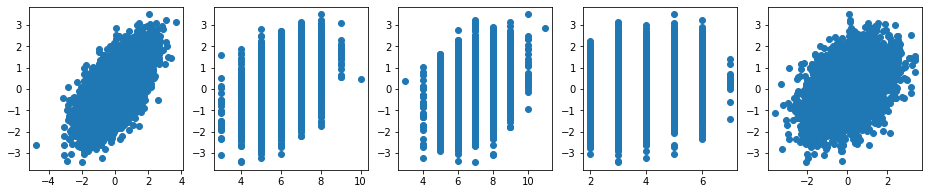

In [23]:
plt.figure(figsize=(16, 3))
plt.subplot(1, 5, 1)
plt.scatter(dataset[['Avg_Area_Income']], dataset[['Price']])
plt.subplot(1, 5, 2)
plt.scatter(dataset[['House_Age']], dataset[['Price']])
plt.subplot(1, 5, 3)
plt.scatter(dataset[['Rooms']], dataset[['Price']])
plt.subplot(1, 5, 4)
plt.scatter(dataset[['Bedrooms']], dataset[['Price']])
plt.subplot(1, 5, 5)
plt.scatter(dataset[['Area_Population']], dataset[['Price']])
plt.show()

In [24]:
x = dataset[['Avg_Area_Income', 'Area_Population']].to_numpy()
y = dataset[['Price']].to_numpy()

thetas, iters, error, errors = descenso_gradiente_estocastico(x, y, alpha=0.05, error=0.001, max_iter=100000, sample_size=128)
print(thetas, iters, error)

[[0.0021]
 [0.6678]
 [0.4156]] 83 0.0009859017327293617


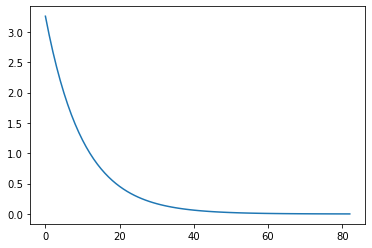

In [25]:
plt.plot(np.arange(iters), errors)
plt.show()

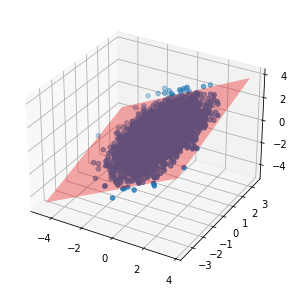

In [26]:
%matplotlib widget

fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(projection="3d")
x1 = np.linspace(x[:,0].min(), x[:,0].max(), 100)
y1 = np.linspace(x[:,1].min(), x[:,1].max(), 100)
X, Y = np.meshgrid(x1, y1)

Xp = np.concatenate(
    [
        np.ones(X.shape).ravel()[:, np.newaxis],
        X.ravel()[:, np.newaxis], 
        Y.ravel()[:, np.newaxis]
    ],
    axis=1
)

Z = np.dot(Xp, thetas).reshape((100, 100))

ax.scatter(x[:, 0], x[:, 1], y, c='C0')
ax.plot_surface(X, Y, Z, color='red', alpha=0.35)
fig.tight_layout()
